In this notebook we test the last version of the data loader, where the files are selected by looking at an inventory file. The interface is unchanged with respect to before but in this case the loading is much faster when asking for high time resolution.

In [1]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from matplotlib.pyplot import imshow

import torch
from torch import nn, optim
from sdo.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sdo.models.encoder_decoder import AutoEncoder

%matplotlib inline

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [3]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA']
channels = ['0171', '0193', '0304']

In [4]:
#some cuda initialization
torch.backends.cudnn.enabled = True
cuda_device = 3
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
device, torch.cuda.current_device(), torch.cuda.device_count()))

Using device cuda:3 for training, current device: 0, total devices: 6


The ratio beetween maximum and found timestamps highly depends on the combination of channels and years

In [11]:
%%time
train_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                         mnt_step=1, day_step=1, h_step=1, min_step=6, subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)

[2019-07-22 00:56:40] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-22 00:56:40] INFO:sdo.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Timestamps requested values: 
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Years: 2011,2012,2013,2014,2015,2016,2017,2018
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Hours: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
[2019-07-22 00:56:40] DEBUG:sdo.sdo_dataset:Minutes: 0,6,12,18,24,30,36,42,48,54,60
[2019-07-22 00:56:40] INFO:sdo.sdo_dataset:Max number of timestamps: 477400
[2019-07-22 00:56:44] INFO:sdo.sdo_dataset:Timestamps found in the inventory: 389767 (0.82)
[2019-07-22 00:57:50] INFO:sdo.sdo_dataset:N timestamps discarded because channel i

In [7]:
%%time
test_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                        mnt_step=1, day_step=1, h_step=1, min_step=6, subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)

[2019-07-22 00:48:52] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-22 00:48:52] INFO:sdo.sdo_dataset:Testing on months "[ 8  9 10]"
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Timestamps requested values: 
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Years: 2011,2012,2013,2014,2015,2016,2017,2018
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Months: 8,9,10
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Hours: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
[2019-07-22 00:48:52] DEBUG:sdo.sdo_dataset:Minutes: 0,6,12,18,24,30,36,42,48,54,60
[2019-07-22 00:48:52] INFO:sdo.sdo_dataset:Max number of timestamps: 204600
[2019-07-22 00:48:55] INFO:sdo.sdo_dataset:Timestamps found in the inventory: 165005 (0.81)
[2019-07-22 00:49:24] INFO:sdo.sdo_dataset:N timestamps discarded because channel is missing = 4

In [12]:
train_data_loader = DataLoader(train_data, batch_size=10, shuffle=True)

0 torch.Size([10, 3, 512, 512])
0171
tensor(4.8843, device='cuda:3') tensor(0., device='cuda:3')
tensor([[5.7622e-04, 1.3183e-04, 3.6970e-04,  ..., 8.0758e-04, 1.5113e-04,
         0.0000e+00],
        [2.3640e-04, 1.6444e-04, 4.9538e-04,  ..., 1.4345e-04, 9.6681e-05,
         1.3041e-04],
        [3.7054e-04, 3.9176e-04, 4.9657e-04,  ..., 1.4502e-04, 2.0947e-04,
         5.7356e-04],
        ...,
        [2.0571e-04, 1.2891e-04, 4.6606e-04,  ..., 1.6570e-04, 2.3168e-04,
         0.0000e+00],
        [1.1878e-04, 1.1193e-04, 2.1610e-04,  ..., 2.6286e-04, 3.0220e-04,
         6.9385e-05],
        [2.3141e-04, 2.8803e-04, 3.3923e-04,  ..., 2.9381e-04, 2.5504e-04,
         0.0000e+00]], device='cuda:3')
4.8843303 0.0 0.24564719 0.17641118
0193
tensor(3.1505, device='cuda:3') tensor(0., device='cuda:3')
tensor([[2.7593e-04, 2.0160e-04, 1.7055e-04,  ..., 3.3613e-04, 3.6904e-04,
         2.2783e-04],
        [2.4346e-04, 2.1564e-04, 1.8918e-04,  ..., 1.3655e-04, 2.7419e-04,
         1.8425e-

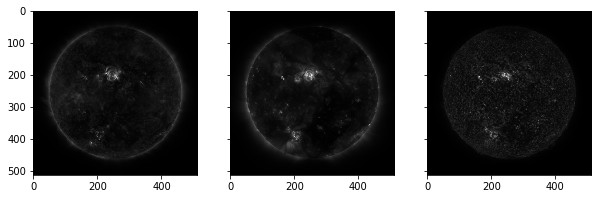

In [14]:
# just selecting one single image at random
#a way to check the shape is as expected and the loader works
for batch_index, batch in enumerate(train_data_loader):
    print(batch_index, batch.shape)
    fig, ax = plt.subplots(1, 3, figsize=(10,10), sharey=True)
    for i in range(len(channels)):
        print(channels[i])
        item = batch[4,i,:,:]
        print(torch.max(item), torch.min(item))
        print(item)
        print(item.cpu().numpy().max(), item.cpu().numpy().min(), item.cpu().numpy().std(), np.median(item.cpu().numpy()))
        ax[i].imshow(batch[4,i,:,:].cpu().numpy(), cmap='gray')
    break

In [15]:
# initializaion of DNN model and parameters
model = AutoEncoder(input_shape=[len(channels), img_shape,img_shape])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Autoencoder architecture:
Input shape: [3, 512, 512]
Input dim  : 786432
Encoded dim: 57600
Hidden dim : 512
Learnable params: 59669699


Interrupted because it is too slow to run it in the notebook but it works

In [16]:
# training loop
model.cuda(cuda_device)
len_data = train_data.__len__()
log_interval = 10
n_epochs = 4
train_loss = []
for epoch in range(n_epochs):
    for batch_index, batch in enumerate(train_data_loader):
        data = batch.to(cuda_device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        train_loss.append(float(loss))
        loss.backward()
        optimizer.step()
        if batch_index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_index * len(data), len_data, 
                100.*(batch_index* len(data)) / len_data, 
                loss.item() / len(data)))

Train Epoch: 0 [0/387851 (0%)]	Loss: 0.010109
Train Epoch: 0 [100/387851 (0%)]	Loss: 0.011816
Train Epoch: 0 [200/387851 (0%)]	Loss: 0.008906
Train Epoch: 0 [300/387851 (0%)]	Loss: 0.006792
Train Epoch: 0 [400/387851 (0%)]	Loss: 0.004802
Train Epoch: 0 [500/387851 (0%)]	Loss: 0.004703
Train Epoch: 0 [600/387851 (0%)]	Loss: 0.004822
Train Epoch: 0 [700/387851 (0%)]	Loss: 0.003882
Train Epoch: 0 [800/387851 (0%)]	Loss: 0.002998
Train Epoch: 0 [900/387851 (0%)]	Loss: 0.009391
Train Epoch: 0 [1000/387851 (0%)]	Loss: 0.002756
Train Epoch: 0 [1100/387851 (0%)]	Loss: 0.003397
Train Epoch: 0 [1200/387851 (0%)]	Loss: 0.002360
Train Epoch: 0 [1300/387851 (0%)]	Loss: 0.002351
Train Epoch: 0 [1400/387851 (0%)]	Loss: 0.003772
Train Epoch: 0 [1500/387851 (0%)]	Loss: 0.002189
Train Epoch: 0 [1600/387851 (0%)]	Loss: 0.003313
Train Epoch: 0 [1700/387851 (0%)]	Loss: 0.002785
Train Epoch: 0 [1800/387851 (0%)]	Loss: 0.002017
Train Epoch: 0 [1900/387851 (0%)]	Loss: 0.002067
Train Epoch: 0 [2000/387851 (1%)

KeyboardInterrupt: 